# 🎯 YOLO11 다중 레이어 객체 검출 튜토리얼

이 노트북은 여러 YOLO 모델을 계층적으로 사용하여 더 정밀한 객체 검출을 수행하는 방법을 학습합니다.

## 📚 학습 목표
1. 다중 레이어 검출의 개념 이해
2. 계층적 모델 구성 방법 학습
3. 레이어별 결과 통합 및 최적화
4. 실제 이미지에 적용 및 시각화

---

## Part 1: 환경 설정 및 라이브러리 임포트

필요한 라이브러리를 설치하고 임포트합니다.

In [34]:
# 필요한 패키지 설치
!pip install ultralytics opencv-python matplotlib numpy pillow

# 라이브러리 임포트
import cv2
import numpy as np
from ultralytics import YOLO
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import json
from datetime import datetime
from typing import List, Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# GPU 사용 가능 여부 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"🖥️ 사용 디바이스: {device}")
if device == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   메모리: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

🖥️ 사용 디바이스: cpu


## Part 2: 다중 레이어 검출 개념 이해

### 왜 다중 레이어를 사용하는가?

1. **속도와 정확도의 균형**: 빠른 모델로 전체 스캔 → 느리지만 정확한 모델로 정밀 검출
2. **다양한 크기의 객체 검출**: 각 모델이 다른 크기의 객체에 특화
3. **False Positive 감소**: 여러 모델의 결과를 종합하여 오탐지 감소
4. **세그멘테이션 통합**: 바운딩 박스와 픽셀 단위 분할 동시 수행

In [35]:
# 레이어 구성 이해하기
layer_config = [
    {
        'name': 'Layer 1: 빠른 스캔',
        'model': 'yolo11n.pt',  # Nano - 가장 빠름 (3.2M 파라미터)
        'purpose': '전체 이미지에서 빠르게 객체 영역 탐지',
        'fps': '100+',
        'mAP': '37.3',
        'best_for': '실시간 처리, 대략적 위치 파악'
    },
    {
        'name': 'Layer 2: 일반 검출',
        'model': 'yolo11s.pt',  # Small (11.2M 파라미터)
        'purpose': '중간 정확도로 객체 분류 및 위치 정제',
        'fps': '80+',
        'mAP': '44.9',
        'best_for': '일반적인 객체 검출'
    },
    {
        'name': 'Layer 3: 정밀 검출',
        'model': 'yolo11m.pt',  # Medium (25.9M 파라미터)
        'purpose': '높은 정확도로 최종 검출 수행',
        'fps': '50+',
        'mAP': '50.2',
        'best_for': '작은 객체, 겹친 객체'
    },
    {
        'name': 'Layer 4: 세그멘테이션',
        'model': 'yolo11n-seg.pt',  # Segmentation
        'purpose': '픽셀 단위 정밀 분할',
        'fps': '60+',
        'mAP': '41.0',
        'best_for': '객체 윤곽, 면적 계산'
    }
]

# 레이어 정보 시각화
import pandas as pd
df = pd.DataFrame(layer_config)
print("🔍 다중 레이어 구성:")
print("="*80)
for idx, layer in enumerate(layer_config, 1):
    print(f"\n{layer['name']}")
    print(f"  • 모델: {layer['model']}")
    print(f"  • 목적: {layer['purpose']}")
    print(f"  • FPS: {layer['fps']}, mAP: {layer['mAP']}")
    print(f"  • 최적 사용: {layer['best_for']}")

🔍 다중 레이어 구성:

Layer 1: 빠른 스캔
  • 모델: yolo11n.pt
  • 목적: 전체 이미지에서 빠르게 객체 영역 탐지
  • FPS: 100+, mAP: 37.3
  • 최적 사용: 실시간 처리, 대략적 위치 파악

Layer 2: 일반 검출
  • 모델: yolo11s.pt
  • 목적: 중간 정확도로 객체 분류 및 위치 정제
  • FPS: 80+, mAP: 44.9
  • 최적 사용: 일반적인 객체 검출

Layer 3: 정밀 검출
  • 모델: yolo11m.pt
  • 목적: 높은 정확도로 최종 검출 수행
  • FPS: 50+, mAP: 50.2
  • 최적 사용: 작은 객체, 겹친 객체

Layer 4: 세그멘테이션
  • 모델: yolo11n-seg.pt
  • 목적: 픽셀 단위 정밀 분할
  • FPS: 60+, mAP: 41.0
  • 최적 사용: 객체 윤곽, 면적 계산


## Part 3: 다중 레이어 검출기 클래스 구현

계층적 검출을 수행하는 핵심 클래스를 구현합니다.

In [36]:
class MultiLayerObjectDetector:
    """
    다중 레이어 객체 검출기
    여러 YOLO 모델을 계층적으로 사용하여 정밀한 검출 수행
    """

    def __init__(self, device='auto'):
        """
        초기화 메서드

        Args:
            device: 실행 디바이스 ('auto', 'cpu', 'cuda')
        """
        # 디바이스 자동 설정
        if device == 'auto':
            self.device = 0 if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device

        print(f"🚀 다중 레이어 검출기 초기화 중...")
        print(f"   디바이스: {self.device}")

        # 레이어별 모델 초기화
        self.layers = self._initialize_layers()

        # COCO 클래스 이름 (80개 클래스)
        self.class_names = None

        # 클래스별 색상 맵
        self.colors = None

    def _initialize_layers(self):
        """
        레이어별 모델 초기화
        각 레이어는 다른 목적과 성능을 가짐
        """
        layers = [
            {
                'name': 'Layer 1: 빠른 스캔',
                'model': YOLO('yolo11n.pt'),  # 가장 빠른 모델
                'confidence': 0.3,  # 낮은 임계값으로 많은 후보 검출
                'iou': 0.5,
                'color': (255, 0, 0)  # Red
            },
            {
                'name': 'Layer 2: 일반 검출',
                'model': YOLO('yolo11s.pt'),  # 균형잡힌 모델
                'confidence': 0.4,
                'iou': 0.45,
                'color': (0, 255, 0)  # Green
            },
            {
                'name': 'Layer 3: 정밀 검출',
                'model': YOLO('yolo11m.pt'),  # 정확한 모델
                'confidence': 0.5,  # 높은 임계값으로 확실한 것만
                'iou': 0.4,
                'color': (0, 0, 255)  # Blue
            },
            {
                'name': 'Layer 4: 세그멘테이션',
                'model': YOLO('yolo11n-seg.pt'),  # 픽셀 단위 분할
                'confidence': 0.5,
                'iou': 0.4,
                'color': (255, 255, 0)  # Yellow
            }
        ]

        print("\n📊 레이어 구성 완료:")
        for layer in layers:
            print(f"   ✓ {layer['name']}")

        return layers

## Part 4: 검출 결과 처리 및 통합

각 레이어의 검출 결과를 처리하고 통합하는 방법을 구현합니다.

In [37]:
def parse_detection_results(result, layer_idx: int):
    """
    YOLO 검출 결과를 파싱하여 표준 형식으로 변환

    Args:
        result: YOLO 모델의 검출 결과
        layer_idx: 레이어 인덱스 (어느 레이어에서 검출되었는지)

    Returns:
        list: 파싱된 검출 결과 리스트
    """
    detections = []

    # 바운딩 박스 처리
    if hasattr(result, 'boxes') and result.boxes is not None:
        for box in result.boxes:
            # 좌표 추출 (x1, y1, x2, y2)
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()

            # 클래스 ID와 신뢰도
            cls_id = int(box.cls[0])
            confidence = float(box.conf[0])

            detection = {
                'bbox': [float(x1), float(y1), float(x2), float(y2)],
                'class_id': cls_id,
                'confidence': confidence,
                'layer': layer_idx,
                'center': [(x1 + x2) / 2, (y1 + y2) / 2],
                'area': (x2 - x1) * (y2 - y1)
            }
            detections.append(detection)

    # 세그멘테이션 마스크 처리 (Layer 4)
    if hasattr(result, 'masks') and result.masks is not None:
        for i, mask in enumerate(result.masks):
            if i < len(detections):
                # 마스크 좌표를 폴리곤으로 변환
                if hasattr(mask, 'xy') and len(mask.xy) > 0:
                    detections[i]['mask'] = mask.xy[0].tolist()
                    detections[i]['has_mask'] = True

    return detections

# 테스트
print("✅ 검출 결과 파싱 함수 정의 완료")
print("\n📌 이 함수는 다음을 수행합니다:")
print("  1. 바운딩 박스 좌표 추출")
print("  2. 클래스 ID와 신뢰도 저장")
print("  3. 중심점과 면적 계산")
print("  4. 세그멘테이션 마스크 처리 (있는 경우)")

✅ 검출 결과 파싱 함수 정의 완료

📌 이 함수는 다음을 수행합니다:
  1. 바운딩 박스 좌표 추출
  2. 클래스 ID와 신뢰도 저장
  3. 중심점과 면적 계산
  4. 세그멘테이션 마스크 처리 (있는 경우)


In [38]:
def calculate_iou(box1: List[float], box2: List[float]) -> float:
    """
    두 바운딩 박스의 IoU (Intersection over Union) 계산

    IoU는 두 박스가 얼마나 겹치는지를 나타내는 지표입니다.
    1에 가까울수록 많이 겹치고, 0이면 전혀 겹치지 않습니다.

    Args:
        box1, box2: [x1, y1, x2, y2] 형식의 바운딩 박스

    Returns:
        float: IoU 값 (0~1)
    """
    # 교집합 영역 계산
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # 교집합 면적
    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    # 각 박스의 면적
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # 합집합 면적
    union = area1 + area2 - intersection

    # IoU 계산
    iou = intersection / union if union > 0 else 0

    return iou

# IoU 계산 예시
box_a = [100, 100, 200, 200]  # 100x100 크기
box_b = [150, 150, 250, 250]  # 100x100 크기, 50픽셀 겹침
iou_value = calculate_iou(box_a, box_b)
print(f"📐 IoU 계산 예시:")
print(f"  Box A: {box_a}")
print(f"  Box B: {box_b}")
print(f"  IoU: {iou_value:.3f}")
print(f"\n💡 IoU = {iou_value:.3f}는 약 {iou_value*100:.1f}% 겹친다는 의미입니다.")

📐 IoU 계산 예시:
  Box A: [100, 100, 200, 200]
  Box B: [150, 150, 250, 250]
  IoU: 0.143

💡 IoU = 0.143는 약 14.3% 겹친다는 의미입니다.


In [39]:
def merge_multi_layer_detections(all_detections: List[Dict], iou_threshold: float = 0.5):
    """
    다중 레이어의 검출 결과를 통합하고 중복 제거

    여러 레이어에서 같은 객체를 검출할 수 있으므로,
    중복을 제거하고 가장 신뢰도 높은 검출만 유지합니다.

    Args:
        all_detections: 모든 레이어의 검출 결과
        iou_threshold: 중복 판단 기준 IoU 값

    Returns:
        list: 중복이 제거된 최종 검출 결과
    """
    if not all_detections:
        return []

    # 신뢰도 순으로 정렬 (높은 것부터)
    sorted_detections = sorted(all_detections, key=lambda x: x['confidence'], reverse=True)

    # 최종 검출 결과
    final_detections = []

    for detection in sorted_detections:
        is_duplicate = False

        # 이미 선택된 검출과 비교
        for final_det in final_detections:
            # 같은 클래스인 경우만 비교
            if detection['class_id'] == final_det['class_id']:
                iou = calculate_iou(detection['bbox'], final_det['bbox'])

                # IoU가 임계값 이상이면 중복으로 판단
                if iou > iou_threshold:
                    # 더 높은 신뢰도를 가진 검출 정보 유지
                    if detection['confidence'] > final_det['confidence']:
                        # 기존 것을 새것으로 교체
                        final_det.update(detection)
                    is_duplicate = True
                    break

        # 중복이 아니면 추가
        if not is_duplicate:
            final_detections.append(detection)

    print(f"🔄 통합 결과:")
    print(f"  • 전체 검출: {len(all_detections)}개")
    print(f"  • 중복 제거 후: {len(final_detections)}개")
    print(f"  • 제거된 중복: {len(all_detections) - len(final_detections)}개")

    return final_detections

print("✅ 다중 레이어 통합 함수 정의 완료")
print("\n📌 NMS (Non-Maximum Suppression) 알고리즘:")
print("  1. 신뢰도 순으로 정렬")
print("  2. 높은 신뢰도부터 선택")
print("  3. IoU로 중복 판단")
print("  4. 중복 제거 및 최적 결과 유지")

✅ 다중 레이어 통합 함수 정의 완료

📌 NMS (Non-Maximum Suppression) 알고리즘:
  1. 신뢰도 순으로 정렬
  2. 높은 신뢰도부터 선택
  3. IoU로 중복 판단
  4. 중복 제거 및 최적 결과 유지


## Part 5: 실제 이미지에 다중 레이어 검출 적용

샘플 이미지를 다운로드하고 다중 레이어 검출을 수행합니다.

📥 온라인 이미지 다운로드 중: https://img1.daumcdn.net/thumb/R1280x0.fjpg/?fname=http://t1.daumcdn.net/brunch/service/user/8LV9/image/LiD1qzzvmaq7ZqrXwUbk8titfKA.jpg
✅ 다운로드 완료: sample_image.jpg


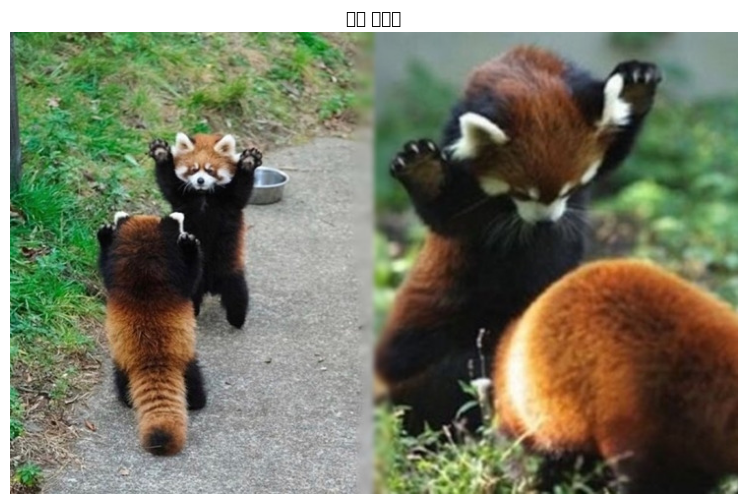


📊 이미지 정보:
  • 크기: 740 x 470
  • 모드: RGB


In [40]:
import os
import urllib.request
from urllib.parse import urlparse

def get_image_path(user_image_path: str = None):
    """사용자 이미지를 제공하거나, 기본 샘플 이미지를 다운로드 및 사용"""

    output_path = "sample_image.jpg" # 기본 출력 파일명

    if user_image_path:
        # URL인지 확인
        parsed_url = urlparse(user_image_path)
        if parsed_url.scheme in ['http', 'https']:
            print(f"📥 온라인 이미지 다운로드 중: {user_image_path}")
            try:
                urllib.request.urlretrieve(user_image_path, output_path)
                print(f"✅ 다운로드 완료: {output_path}")
            except Exception as e:
                print(f"❌ 이미지 다운로드 실패: {e}. 기본 샘플 이미지를 사용합니다.")
                # 다운로드 실패 시 기본 샘플 URL 사용
                url = "https://ultralytics.com/images/bus.jpg"
                urllib.request.urlretrieve(url, output_path)
                print(f"✅ 기본 샘플 이미지 다운로드 완료: {output_path}")
        elif os.path.exists(user_image_path):
            print(f"✅ 사용자 이미지 경로 사용: {user_image_path}")
            output_path = user_image_path # 로컬 파일인 경우 경로를 직접 사용
        else:
            print(f"❌ 지정된 로컬 이미지 파일이 없습니다: {user_image_path}. 기본 샘플 이미지를 사용합니다.")
            url = "https://ultralytics.com/images/bus.jpg"
            if not os.path.exists(output_path):
                urllib.request.urlretrieve(url, output_path)
                print(f"✅ 기본 샘플 이미지 다운로드 완료: {output_path}")
            else:
                print(f"✅ 기본 샘플 이미지가 이미 존재합니다: {output_path}")
    else:
        # 기본 샘플 이미지 URL (복잡한 거리 장면)
        url = "https://ultralytics.com/images/bus.jpg"
        if not os.path.exists(output_path):
            print("📥 샘플 이미지 다운로드 중...")
            urllib.request.urlretrieve(url, output_path)
            print(f"✅ 다운로드 완료: {output_path}")
        else:
            print(f"✅ 이미지가 이미 존재합니다: {output_path}")

    # 이미지 표시
    img = Image.open(output_path)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.title("분석 이미지")
    plt.axis('off')
    plt.show()

    print(f"\n📊 이미지 정보:")
    print(f"  • 크기: {img.size[0]} x {img.size[1]}")
    print(f"  • 모드: {img.mode}")

    return output_path

# 여기에 사용자 이미지 경로를 입력하세요. (예: 'my_image.jpg' 또는 'http://example.com/image.jpg')
# 만약 None으로 두면 샘플 이미지가 사용됩니다.
user_provided_image_path = 'https://img1.daumcdn.net/thumb/R1280x0.fjpg/?fname=http://t1.daumcdn.net/brunch/service/user/8LV9/image/LiD1qzzvmaq7ZqrXwUbk8titfKA.jpg'
# 샘플 이미지 다운로드 또는 사용자 이미지 경로 사용
sample_image_path = get_image_path(user_provided_image_path)


In [41]:
def perform_multi_layer_detection(image_path: str, detector: MultiLayerObjectDetector):
    """
    다중 레이어 검출 수행

    Args:
        image_path: 입력 이미지 경로
        detector: 다중 레이어 검출기

    Returns:
        dict: 검출 결과
    """
    print(f"\n🔍 다중 레이어 검출 시작: {image_path}")
    print("="*60)

    # 이미지 로드
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 각 레이어별 결과 저장
    layer_results = []
    all_detections = []

    # 각 레이어 실행
    for i, layer in enumerate(detector.layers):
        print(f"\n⚙️ {layer['name']} 실행 중...")

        # 검출 수행
        results = layer['model'](
            image,
            conf=layer['confidence'],
            iou=layer['iou'],
            verbose=False,
            device=detector.device
        )

        # 결과 파싱
        detections = parse_detection_results(results[0], i)

        if detections:
            layer_results.append({
                'layer_name': layer['name'],
                'detections': detections,
                'count': len(detections)
            })
            all_detections.extend(detections)
            print(f"   ✓ {len(detections)}개 객체 검출")
        else:
            print(f"   - 검출된 객체 없음")

    # 클래스 이름 설정
    if detector.class_names is None and layer_results:
        detector.class_names = detector.layers[0]['model'].names

    # 검출 결과 통합
    print("\n🔄 검출 결과 통합 중...")
    final_detections = merge_multi_layer_detections(all_detections)

    return {
        'image': image_rgb,
        'layer_results': layer_results,
        'final_detections': final_detections,
        'all_detections': all_detections
    }

# 검출기 생성 및 실행
detector = MultiLayerObjectDetector()
detection_results = perform_multi_layer_detection(sample_image_path, detector)

🚀 다중 레이어 검출기 초기화 중...
   디바이스: cpu

📊 레이어 구성 완료:
   ✓ Layer 1: 빠른 스캔
   ✓ Layer 2: 일반 검출
   ✓ Layer 3: 정밀 검출
   ✓ Layer 4: 세그멘테이션

🔍 다중 레이어 검출 시작: sample_image.jpg

⚙️ Layer 1: 빠른 스캔 실행 중...
   ✓ 7개 객체 검출

⚙️ Layer 2: 일반 검출 실행 중...
   ✓ 5개 객체 검출

⚙️ Layer 3: 정밀 검출 실행 중...
   ✓ 5개 객체 검출

⚙️ Layer 4: 세그멘테이션 실행 중...
   ✓ 4개 객체 검출

🔄 검출 결과 통합 중...
🔄 통합 결과:
  • 전체 검출: 21개
  • 중복 제거 후: 8개
  • 제거된 중복: 13개


## Part 6: 검출 결과 시각화

각 레이어별 결과와 최종 통합 결과를 시각화합니다.

In [42]:
def visualize_layer_results(results: dict, detector: MultiLayerObjectDetector):
    """
    레이어별 검출 결과 시각화

    각 레이어가 무엇을 검출했는지 개별적으로 보여줍니다.
    """
    num_layers = len(results['layer_results'])

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    # 각 레이어 결과 그리기
    for i, layer_result in enumerate(results['layer_results']):
        ax = axes[i]
        ax.imshow(results['image'])
        ax.set_title(f"{layer_result['layer_name']}\n({layer_result['count']}개 검출)", fontsize=12)
        ax.axis('off')

        # 검출된 객체 그리기
        for det in layer_result['detections']:
            bbox = det['bbox']
            x1, y1, x2, y2 = bbox

            # 색상 값을 0-1 범위로 정규화
            color_255 = detector.layers[i]['color']
            color_normalized = (color_255[0]/255, color_255[1]/255, color_255[2]/255)

            # 바운딩 박스
            rect = patches.Rectangle(
                (x1, y1), x2-x1, y2-y1,
                linewidth=2,
                edgecolor=color_normalized,
                facecolor='none',
                alpha=0.8
            )
            ax.add_patch(rect)

            # 신뢰도 표시
            if detector.class_names:
                class_name = detector.class_names.get(det['class_id'], 'unknown')
                label = f"{class_name}: {det['confidence']:.2f}"
                ax.text(x1, y1-5, label, fontsize=8,
                       bbox=dict(boxstyle="round,pad=0.3",
                                facecolor=color_normalized,
                                alpha=0.7),
                       color='white')

    # 빈 subplot 숨기기
    for i in range(num_layers, len(axes)):
        axes[i].axis('off')

    plt.suptitle("레이어별 검출 결과", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [49]:
def visualize_final_results(results: dict, detector: MultiLayerObjectDetector, output_filename: str = None):
    """
    최종 통합 결과 시각화

    모든 레이어의 결과를 통합한 최종 검출 결과를 보여줍니다.
    Args:
        results: 검출 결과 딕셔너리
        detector: MultiLayerObjectDetector 객체
        output_filename: 이미지를 저장할 파일 경로 (선택 사항)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # 왼쪽: 모든 검출 (통합 전)
    ax1.imshow(results['image'])
    ax1.set_title(f"모든 레이어 검출 (통합 전)\n총 {len(results['all_detections'])}개", fontsize=12)
    ax1.axis('off')

    # 모든 검출 그리기 (반투명)
    for det in results['all_detections']:
        bbox = det['bbox']
        x1, y1, x2, y2 = bbox
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=1,
            edgecolor='gray',
            facecolor='none',
            alpha=0.3
        )
        ax1.add_patch(rect)

    # 오른쪽: 최종 통합 결과
    ax2.imshow(results['image'])
    ax2.set_title(f"최종 통합 결과 (중복 제거)\n총 {len(results['final_detections'])}개", fontsize=12)
    ax2.axis('off')

    # 클래스별 색상 생성
    if detector.class_names:
        num_classes = len(detector.class_names)
        colors = plt.cm.hsv(np.linspace(0, 1, num_classes))

    # 최종 검출 그리기
    for det in results['final_detections']:
        bbox = det['bbox']
        x1, y1, x2, y2 = bbox

        # 클래스별 색상
        if detector.class_names:
            color = colors[det['class_id'] % num_classes]
        else:
            color = 'green'

        # 바운딩 박스
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=2,
            edgecolor=color,
            facecolor='none',
            alpha=0.8
        )
        ax2.add_patch(rect)

        # 라벨
        if detector.class_names:
            class_name = detector.class_names.get(det['class_id'], 'unknown')
            label = f"{class_name}: {det['confidence']:.2f}"
            ax2.text(x1, y1-5, label, fontsize=9,
                    bbox=dict(boxstyle="round,pad=0.3",
                            facecolor=color, alpha=0.7),
                    color='white')

    plt.suptitle("다중 레이어 검출: 통합 전 vs 통합 후", fontsize=16, fontweight='bold')
    plt.tight_layout()

    if output_filename:
        plt.savefig(output_filename, dpi=100, bbox_inches='tight')
        print(f"✅ 결과 이미지 저장: {output_filename}")

    plt.show()

# 레이어별 결과 시각화
visualize_layer_results(detection_results, detector)

# 최종 결과 시각화 및 저장
output_dir_for_results = "detection_results"
Path(output_dir_for_results).mkdir(exist_ok=True) # Ensure directory exists
visualize_final_results(detection_results, detector, output_filename=f"{output_dir_for_results}/result2.jpg")


Output hidden; open in https://colab.research.google.com to view.

## Part 7: 성능 분석 및 통계

다중 레이어 검출의 성능을 분석하고 통계를 출력합니다.

In [44]:
def analyze_detection_statistics(results: dict, detector: MultiLayerObjectDetector):
    """
    검출 통계 분석 및 출력
    """
    print("\n" + "="*60)
    print("📊 다중 레이어 검출 통계 분석")
    print("="*60)

    # 1. 레이어별 통계
    print("\n1️⃣ 레이어별 검출 수:")
    for result in results['layer_results']:
        print(f"  • {result['layer_name']}: {result['count']}개")

    # 2. 통합 효과
    total_before = len(results['all_detections'])
    total_after = len(results['final_detections'])
    reduction_rate = (1 - total_after/total_before) * 100 if total_before > 0 else 0

    print(f"\n2️⃣ 중복 제거 효과:")
    print(f"  • 통합 전: {total_before}개")
    print(f"  • 통합 후: {total_after}개")
    print(f"  • 중복 제거: {total_before - total_after}개 ({reduction_rate:.1f}%)")

    # 3. 클래스별 분포
    if detector.class_names and results['final_detections']:
        class_counts = {}
        for det in results['final_detections']:
            class_name = detector.class_names.get(det['class_id'], 'unknown')
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

        print(f"\n3️⃣ 클래스별 분포 (최종):")
        for class_name, count in sorted(class_counts.items(), key=lambda x: x[1], reverse=True):
            percentage = (count / total_after) * 100
            print(f"  • {class_name}: {count}개 ({percentage:.1f}%)")

    # 4. 신뢰도 분석
    if results['final_detections']:
        confidences = [det['confidence'] for det in results['final_detections']]

        print(f"\n4️⃣ 신뢰도 통계 (최종):")
        print(f"  • 평균: {np.mean(confidences):.3f}")
        print(f"  • 최대: {np.max(confidences):.3f}")
        print(f"  • 최소: {np.min(confidences):.3f}")
        print(f"  • 표준편차: {np.std(confidences):.3f}")

    # 5. 레이어별 기여도
    layer_contributions = {}
    for det in results['final_detections']:
        layer_idx = det['layer']
        layer_name = detector.layers[layer_idx]['name']
        layer_contributions[layer_name] = layer_contributions.get(layer_name, 0) + 1

    if layer_contributions:
        print(f"\n5️⃣ 레이어별 기여도 (최종 결과에 포함된 검출):")
        for layer_name, count in layer_contributions.items():
            percentage = (count / total_after) * 100
            print(f"  • {layer_name}: {count}개 ({percentage:.1f}%)")

    print("\n" + "="*60)

# 통계 분석 실행
analyze_detection_statistics(detection_results, detector)


📊 다중 레이어 검출 통계 분석

1️⃣ 레이어별 검출 수:
  • Layer 1: 빠른 스캔: 7개
  • Layer 2: 일반 검출: 5개
  • Layer 3: 정밀 검출: 5개
  • Layer 4: 세그멘테이션: 4개

2️⃣ 중복 제거 효과:
  • 통합 전: 21개
  • 통합 후: 8개
  • 중복 제거: 13개 (61.9%)

3️⃣ 클래스별 분포 (최종):
  • bear: 4개 (50.0%)
  • cat: 2개 (25.0%)
  • bowl: 1개 (12.5%)
  • dog: 1개 (12.5%)

4️⃣ 신뢰도 통계 (최종):
  • 평균: 0.682
  • 최대: 0.874
  • 최소: 0.323
  • 표준편차: 0.175

5️⃣ 레이어별 기여도 (최종 결과에 포함된 검출):
  • Layer 4: 세그멘테이션: 1개 (12.5%)
  • Layer 2: 일반 검출: 3개 (37.5%)
  • Layer 3: 정밀 검출: 2개 (25.0%)
  • Layer 1: 빠른 스캔: 2개 (25.0%)



## Part 8: 단일 모델과 다중 레이어 비교

단일 YOLO 모델과 다중 레이어 접근법의 성능을 비교합니다.


⚖️ 단일 모델 vs 다중 레이어 비교

1️⃣ 단일 모델 (YOLOv11m) 테스트...
  • 검출 수: 5개
  • 처리 시간: 6.218초

2️⃣ 다중 레이어 모델 테스트...
🚀 다중 레이어 검출기 초기화 중...
   디바이스: cpu

📊 레이어 구성 완료:
   ✓ Layer 1: 빠른 스캔
   ✓ Layer 2: 일반 검출
   ✓ Layer 3: 정밀 검출
   ✓ Layer 4: 세그멘테이션

🔍 다중 레이어 검출 시작: sample_image.jpg

⚙️ Layer 1: 빠른 스캔 실행 중...
   ✓ 7개 객체 검출

⚙️ Layer 2: 일반 검출 실행 중...
   ✓ 5개 객체 검출

⚙️ Layer 3: 정밀 검출 실행 중...
   ✓ 5개 객체 검출

⚙️ Layer 4: 세그멘테이션 실행 중...
   ✓ 4개 객체 검출

🔄 검출 결과 통합 중...
🔄 통합 결과:
  • 전체 검출: 21개
  • 중복 제거 후: 8개
  • 제거된 중복: 13개
  • 검출 수: 8개
  • 처리 시간: 2.911초

📈 비교 결과:
  • 검출 개수 차이: 3개 (+60.0%)
  • 처리 시간 차이: -3.306초 (-53.2%)

💡 분석:
  ✅ 다중 레이어가 3개 더 많은 객체를 검출했습니다.
  ⚡ 다중 레이어가 합리적인 시간 내에 처리되었습니다.


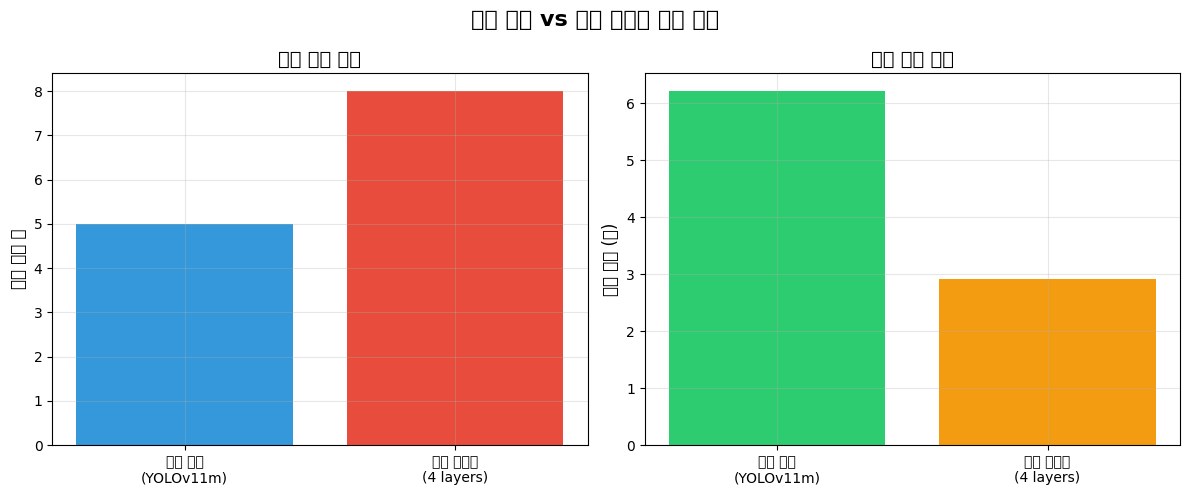

In [45]:
import time

def compare_single_vs_multi_layer(image_path: str):
    """
    단일 모델 vs 다중 레이어 성능 비교
    """
    print("\n" + "="*60)
    print("⚖️ 단일 모델 vs 다중 레이어 비교")
    print("="*60)

    image = cv2.imread(image_path)

    # 1. 단일 모델 (YOLOv11m)
    print("\n1️⃣ 단일 모델 (YOLOv11m) 테스트...")
    single_model = YOLO('yolo11m.pt')

    start_time = time.time()
    single_results = single_model(image, conf=0.5, verbose=False)
    single_time = time.time() - start_time

    single_count = len(single_results[0].boxes) if single_results[0].boxes else 0
    print(f"  • 검출 수: {single_count}개")
    print(f"  • 처리 시간: {single_time:.3f}초")

    # 2. 다중 레이어
    print("\n2️⃣ 다중 레이어 모델 테스트...")
    detector_multi = MultiLayerObjectDetector()

    start_time = time.time()
    multi_results = perform_multi_layer_detection(image_path, detector_multi)
    multi_time = time.time() - start_time

    multi_count = len(multi_results['final_detections'])
    print(f"  • 검출 수: {multi_count}개")
    print(f"  • 처리 시간: {multi_time:.3f}초")

    # 3. 비교 결과
    print("\n📈 비교 결과:")
    print(f"  • 검출 개수 차이: {multi_count - single_count}개 ({(multi_count/max(single_count, 1) - 1)*100:+.1f}%)")
    print(f"  • 처리 시간 차이: {multi_time - single_time:+.3f}초 ({(multi_time/single_time - 1)*100:+.1f}%)")

    # 4. 분석
    print("\n💡 분석:")
    if multi_count > single_count:
        print(f"  ✅ 다중 레이어가 {multi_count - single_count}개 더 많은 객체를 검출했습니다.")
    elif multi_count < single_count:
        print(f"  ⚠️ 다중 레이어가 {single_count - multi_count}개 적은 객체를 검출했습니다.")
        print(f"     (더 엄격한 중복 제거로 인한 것일 수 있음)")
    else:
        print(f"  ➖ 동일한 수의 객체를 검출했습니다.")

    if multi_time > single_time * 1.5:
        print(f"  ⏱️ 다중 레이어가 더 느리지만, 더 포괄적인 검출을 제공합니다.")
    else:
        print(f"  ⚡ 다중 레이어가 합리적인 시간 내에 처리되었습니다.")

    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # 검출 수 비교
    axes[0].bar(['단일 모델\n(YOLOv11m)', '다중 레이어\n(4 layers)'],
                [single_count, multi_count],
                color=['#3498db', '#e74c3c'])
    axes[0].set_ylabel('검출 객체 수', fontsize=12)
    axes[0].set_title('검출 성능 비교', fontsize=14)
    axes[0].grid(True, alpha=0.3)

    # 처리 시간 비교
    axes[1].bar(['단일 모델\n(YOLOv11m)', '다중 레이어\n(4 layers)'],
                [single_time, multi_time],
                color=['#2ecc71', '#f39c12'])
    axes[1].set_ylabel('처리 시간 (초)', fontsize=12)
    axes[1].set_title('처리 속도 비교', fontsize=14)
    axes[1].grid(True, alpha=0.3)

    plt.suptitle('단일 모델 vs 다중 레이어 성능 비교', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return {
        'single': {'count': single_count, 'time': single_time},
        'multi': {'count': multi_count, 'time': multi_time}
    }

# 비교 실행
comparison_results = compare_single_vs_multi_layer(sample_image_path)

## Part 9: 실전 활용 - 사용자 이미지 처리

사용자가 직접 이미지를 업로드하여 다중 레이어 검출을 수행할 수 있습니다.

In [46]:
class InteractiveMultiLayerDetector:
    """
    대화형 다중 레이어 검출기
    사용자가 직접 설정을 조정하며 검출할 수 있습니다.
    """

    def __init__(self):
        self.detector = MultiLayerObjectDetector()
        self.results = None

    def process_image(self, image_path: str,
                     use_layers: List[bool] = [True, True, True, True],
                     iou_threshold: float = 0.5):
        """
        사용자 설정에 따라 이미지 처리

        Args:
            image_path: 이미지 경로
            use_layers: 각 레이어 사용 여부 [Layer1, Layer2, Layer3, Layer4]
            iou_threshold: 중복 제거 IoU 임계값
        """
        print(f"\n🔧 사용자 설정:")
        print(f"  • 이미지: {Path(image_path).name}")
        print(f"  • 활성 레이어: {sum(use_layers)}개")
        print(f"  • IoU 임계값: {iou_threshold}")

        # 이미지 로드
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 선택된 레이어만 실행
        all_detections = []
        layer_results = []

        for i, (layer, use) in enumerate(zip(self.detector.layers, use_layers)):
            if use:
                print(f"\n  ✓ {layer['name']} 실행 중...")
                results = layer['model'](image, conf=layer['confidence'],
                                       iou=layer['iou'], verbose=False)
                detections = parse_detection_results(results[0], i)

                if detections:
                    all_detections.extend(detections)
                    layer_results.append({
                        'layer_name': layer['name'],
                        'count': len(detections)
                    })
                    print(f"     {len(detections)}개 검출")
            else:
                print(f"\n  ✗ {self.detector.layers[i]['name']} 건너뜀")

        # 결과 통합
        final_detections = merge_multi_layer_detections(all_detections, iou_threshold)

        self.results = {
            'image': image_rgb,
            'layer_results': layer_results,
            'final_detections': final_detections,
            'settings': {
                'use_layers': use_layers,
                'iou_threshold': iou_threshold
            }
        }

        return self.results

    def save_results(self, output_dir: str = "detection_results"):
        """
        검출 결과 저장
        """
        if not self.results:
            print("❌ 저장할 결과가 없습니다. 먼저 이미지를 처리하세요.")
            return

        # 디렉토리 생성
        Path(output_dir).mkdir(exist_ok=True)

        # 타임스탬프 (JSON 파일에만 사용)
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

        # 1. 결과 이미지 저장
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(self.results['image'])
        ax.axis('off')

        # 검출 결과 그리기
        for det in self.results['final_detections']:
            bbox = det['bbox']
            x1, y1, x2, y2 = bbox
            rect = patches.Rectangle(
                (x1, y1), x2-x1, y2-y1,
                linewidth=2, edgecolor='red',
                facecolor='none', alpha=0.8
            )
            ax.add_patch(rect)

        # 이미지 파일명은 'result.jpg'로 고정
        image_path = f"{output_dir}/result.jpg"
        plt.savefig(image_path, dpi=100, bbox_inches='tight')
        plt.close()
        print(f"✅ 이미지 저장: {image_path}")

        # 2. JSON 결과 저장
        json_data = {
            'timestamp': timestamp,
            'settings': self.results['settings'],
            'layer_results': self.results['layer_results'],
            'total_detections': len(self.results['final_detections']),
            'detections': self.results['final_detections']
        }

        json_path = f"{output_dir}/detection_{timestamp}.json"
        with open(json_path, 'w', encoding='utf-8') as f:
            json.dump(json_data, f, indent=2, default=str)
        print(f"✅ JSON 저장: {json_path}")

# 대화형 검출기 생성
interactive_detector = InteractiveMultiLayerDetector()

print("🎮 대화형 다중 레이어 검출기 준비 완료!")
print("\n사용 예시:")
print("  results = interactive_detector.process_image('your_image.jpg')")
print("  interactive_detector.save_results()")


🚀 다중 레이어 검출기 초기화 중...
   디바이스: cpu

📊 레이어 구성 완료:
   ✓ Layer 1: 빠른 스캔
   ✓ Layer 2: 일반 검출
   ✓ Layer 3: 정밀 검출
   ✓ Layer 4: 세그멘테이션
🎮 대화형 다중 레이어 검출기 준비 완료!

사용 예시:
  results = interactive_detector.process_image('your_image.jpg')
  interactive_detector.save_results()


In [47]:
# 사용자 설정 예제: 특정 레이어만 사용
print("📝 사용자 설정 예제")
print("="*60)

# 예제 1: Layer 1, 3만 사용 (빠른 스캔 + 정밀 검출)
print("\n예제 1: 빠른 스캔 + 정밀 검출 조합")
results_custom1 = interactive_detector.process_image(
    sample_image_path,
    use_layers=[True, False, True, False],  # Layer 1, 3만 활성화
    iou_threshold=0.4  # 더 관대한 중복 허용
)

print(f"\n결과: {len(results_custom1['final_detections'])}개 객체 검출")

# 최종 결과 이미지를 'result.jpg'로 저장
interactive_detector.save_results()

📝 사용자 설정 예제

예제 1: 빠른 스캔 + 정밀 검출 조합

🔧 사용자 설정:
  • 이미지: sample_image.jpg
  • 활성 레이어: 2개
  • IoU 임계값: 0.4

  ✓ Layer 1: 빠른 스캔 실행 중...
     7개 검출

  ✗ Layer 2: 일반 검출 건너뜀

  ✓ Layer 3: 정밀 검출 실행 중...
     5개 검출

  ✗ Layer 4: 세그멘테이션 건너뜀
🔄 통합 결과:
  • 전체 검출: 12개
  • 중복 제거 후: 7개
  • 제거된 중복: 5개

결과: 7개 객체 검출
✅ 이미지 저장: detection_results/result.jpg
✅ JSON 저장: detection_results/detection_20251121_062752.json


## Part 10: 결론 및 최적화 팁

다중 레이어 검출의 장단점과 최적화 방법을 정리합니다.

In [48]:
print("\n" + "="*80)
print("📚 다중 레이어 객체 검출 - 핵심 정리")
print("="*80)

print("""
✅ 장점:
  1. 더 많은 객체 검출 가능 (특히 작거나 겹친 객체)
  2. False Positive 감소 (여러 모델의 교차 검증)
  3. 다양한 크기와 형태의 객체에 대한 강건성
  4. 세그멘테이션을 통한 정밀한 경계 검출

⚠️ 단점:
  1. 처리 시간 증가 (단일 모델 대비 3-4배)
  2. 메모리 사용량 증가 (여러 모델 로드)
  3. 파라미터 튜닝의 복잡성

🎯 최적화 팁:
  1. 용도에 따라 필요한 레이어만 선택적 사용
  2. IoU 임계값 조정으로 중복 제거 수준 제어
  3. GPU 사용으로 처리 속도 향상
  4. 배치 처리로 여러 이미지 동시 처리

💡 활용 시나리오:
  • 복잡한 장면 분석 (군중, 교통)
  • 의료 영상 (정확도가 중요한 경우)
  • 보안 감시 (놓치면 안 되는 객체)
  • 품질 검사 (작은 결함 검출)

🔧 권장 설정:
  • 실시간 처리: Layer 1만 사용
  • 균형: Layer 1 + Layer 3
  • 최대 정확도: 모든 레이어 사용
  • 세그멘테이션 필요: Layer 4 포함
""")

print("\n" + "="*80)
print("🎉 튜토리얼 완료!")
print("이제 다중 레이어 객체 검출을 활용해보세요!")
print("="*80)


📚 다중 레이어 객체 검출 - 핵심 정리

✅ 장점:
  1. 더 많은 객체 검출 가능 (특히 작거나 겹친 객체)
  2. False Positive 감소 (여러 모델의 교차 검증)
  3. 다양한 크기와 형태의 객체에 대한 강건성
  4. 세그멘테이션을 통한 정밀한 경계 검출

⚠️ 단점:
  1. 처리 시간 증가 (단일 모델 대비 3-4배)
  2. 메모리 사용량 증가 (여러 모델 로드)
  3. 파라미터 튜닝의 복잡성

🎯 최적화 팁:
  1. 용도에 따라 필요한 레이어만 선택적 사용
  2. IoU 임계값 조정으로 중복 제거 수준 제어
  3. GPU 사용으로 처리 속도 향상
  4. 배치 처리로 여러 이미지 동시 처리

💡 활용 시나리오:
  • 복잡한 장면 분석 (군중, 교통)
  • 의료 영상 (정확도가 중요한 경우)
  • 보안 감시 (놓치면 안 되는 객체)
  • 품질 검사 (작은 결함 검출)

🔧 권장 설정:
  • 실시간 처리: Layer 1만 사용
  • 균형: Layer 1 + Layer 3
  • 최대 정확도: 모든 레이어 사용
  • 세그멘테이션 필요: Layer 4 포함


🎉 튜토리얼 완료!
이제 다중 레이어 객체 검출을 활용해보세요!
